# AI200 Capstone Project

This Prediction Challenge is modelled after the 2015 Facebook Recruitment Challenge, a prediction competition jointly held by Facebook and Kaggle.

In this competition, we are chasing down robots for an online auction site. Human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting.

In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions. Their attempt at building a model to identify these bids using behavioral data, including bid frequency over short periods of time, has proven insufficient.

The goal of this competition is to identify online auction bids that are placed by "robots", helping the site owners easily flag these users for removal from their site to prevent unfair auction activity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 99

## Train Dataset

In [2]:
train = pd.read_csv('train.csv')

In [3]:
print('No. of unique bidder_id = {0:}'.format(train['bidder_id'].nunique()))
print('No. of unique payment_account = {0:}'.format(train['payment_account'].nunique()))
print('No. of unique address = {0:}'.format(train['address'].nunique()))

train_human = train[train['outcome'] == 0]
print('\nNo. of humans in train data set: ', len(train_human))

train_bot = train[train['outcome'] == 1]
print('No. of bots in train data set: ', len(train_bot))

No. of unique bidder_id = 2013
No. of unique payment_account = 2013
No. of unique address = 2013

No. of humans in train data set:  1910
No. of bots in train data set:  103


There are no missing values in the train dataset. It contains 2013 unique users.

# Test Dataset

In [4]:
test = pd.read_csv('test.csv')

In [5]:
print('No. of unique bidder_id = {0:}'.format(test['bidder_id'].nunique()))
print('No. of unique payment_account = {0:}'.format(test['payment_account'].nunique()))
print('No. of unique address = {0:}'.format(test['address'].nunique()))

No. of unique bidder_id = 4700
No. of unique payment_account = 4700
No. of unique address = 4700


There are also no missing data in the test dataset. It contains 4700 unique users.

## Combined Train Test Dataset

In [6]:
combine = pd.concat([train, test], axis = 0)

In [7]:
print('No. of unique bidder_id = {0:}'.format(combine['bidder_id'].nunique()))
print('No. of unique payment_account = {0:}'.format(combine['payment_account'].nunique()))
print('No. of unique address = {0:}'.format(combine['address'].nunique()))

No. of unique bidder_id = 6713
No. of unique payment_account = 6713
No. of unique address = 6713


To access the train dataset, we will use combine[:2013]. To access the test dataset, we will use combine[2013:].

## Bids Dataset

In [8]:
bids = pd.read_csv('bids.csv')

In [9]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,c6faf9e526c72bc8383f2bc4417a465d2fa27,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,d96e93359ed70b7b4eebac163f448afeb50dc,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,065bdcc596308d1fdd0014261d6e198aa138e,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,e97aa310037dd210f52b5b164077a926bb5de,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,41a7f56fcc5771d305baa6e989fb2e8cceb21,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


Recap of the data dictionary for bids dataset

* bid_id - unique id for this bid
* bidder_id – Unique identifier of a bidder (same as the bidder_id used in train.csv and test.csv)
* auction – Unique identifier of an auction
* merchandise – The category of the auction site campaign, which means the bidder might come to this site by way of searching for "home goods" but ended up bidding for "sporting goods" - and that leads to this field being "home goods". This categorical field could be a search term, or online advertisement.
* device – Phone model of a visitor
* time - Time that the bid is made (transformed to protect privacy).
* country - The country that the IP belongs to
* ip – IP address of a bidder (obfuscated to protect privacy).
* url - url where the bidder was referred from (obfuscated to protect privacy).

In [10]:
bids.shape

(7656334, 9)

The bid dataset contains 7,656,334 unique bids.

In [11]:
print('No. of unique bids = {0:}'.format(bids['bid_id'].nunique()))
print('No. of unique bidder = {0:}'.format(bids['bidder_id'].nunique()))
print('No. of unique auction = {0:}'.format(bids['auction'].nunique()))
print('No. of unique merchandise category = {0:}'.format(bids['merchandise'].nunique()))
print('No. of unique phone model = {0:}'.format(bids['device'].nunique()))
print('No. of unique time bid made = {0:}'.format(bids['time'].nunique()))
print('No. of unique country = {0:}'.format(bids['country'].nunique()))
print('No. of unique IP addresses = {0:}'.format(bids['ip'].nunique()))
print('No. of unique url where bidder referred from = {0:}'.format(bids['url'].nunique()))

No. of unique bids = 7656334
No. of unique bidder = 6614
No. of unique auction = 15051
No. of unique merchandise category = 10
No. of unique phone model = 7351
No. of unique time bid made = 776529
No. of unique country = 199
No. of unique IP addresses = 2303991
No. of unique url where bidder referred from = 1786351


In [12]:
bids.isnull().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

Here we see that there are missing data for the `country` column.

## No. of Average Unique IP/Device/URL/Bids per Auction

As there are varying number of unique IPs, devices, URLs and bids per auction that each bidder participatd in, we will aggregate them by each unique auction. Due to the large span, we choose to use median instead of mean.

In [13]:
full_avg_ip = pd.DataFrame(bids.groupby(['bidder_id', 'auction'])['ip'].agg('nunique').groupby(level=0).median()).reset_index()
full_avg_ip.rename({'ip': 'avg_ip'}, axis=1, inplace=True)

full_avg_device = pd.DataFrame(bids.groupby(['bidder_id', 'auction'])['device'].agg('nunique').groupby(level=0).median()).reset_index()
full_avg_device.rename({'device': 'avg_device'}, axis=1, inplace=True)

full_avg_url = pd.DataFrame(bids.groupby(['bidder_id', 'auction'])['url'].agg('nunique').groupby(level=0).median()).reset_index()
full_avg_url.rename({'url': 'avg_url'}, axis=1, inplace=True)

full_avg_bids = pd.DataFrame(bids.groupby(['bidder_id', 'auction']).size().groupby(level=0).median()).reset_index()
full_avg_bids.rename({0: 'avg_bid'}, axis=1, inplace=True)

full_bids = pd.merge(full_avg_ip, full_avg_device, how = 'left', on = 'bidder_id')
full_bids = pd.merge(full_bids, full_avg_url, how = 'left', on = 'bidder_id')
full_bids = pd.merge(full_bids, full_avg_bids, how = 'left', on = 'bidder_id')

full_bids.head()

,bidder_id,avg_ip,avg_device,avg_url,avg_bid
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.0,1.0,1.0,1.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.0,1.0,1.0,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,1.0,1.0,1.0,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,1.0,1.0,1.0,1.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,1.0,1.0,1.0,1.0


## Create Dataset based on Unique Bidder

We will aggregate the data by each unique bidder, to calculate the sum of each data fields per bidder.

In [14]:
bidder = bids.groupby('bidder_id').nunique().reset_index().drop(columns = ['time'])

In [15]:
bidder['adevice'] = bidder['device'] / bidder['bid_id']
bidder['aauction'] = bidder['auction'] / bidder['bid_id']
bidder['aurl'] = bidder['url'] / bidder['bid_id']
bidder['aip'] = bidder['ip'] / bidder['bid_id']
bidder['amerchandise'] = bidder['merchandise'] / bidder['bid_id']
bidder['acountry'] = bidder['country'] / bidder['bid_id']
bidder.head()

,bidder_id,bid_id,auction,merchandise,device,country,ip,url,adevice,aauction,aurl,aip,amerchandise,acountry
0,0013f9b8d1f462df4462e1c1216e441ba6e18,8,6,1,7,2,8,4,0.875000,0.750000,0.500000,1.000000,0.125000,0.250000
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,7,7,1,7,4,7,4,1.000000,1.000000,0.571429,1.000000,0.142857,0.571429
2,002828f800c5132e297cfe3d44fbde9aeac51,2,2,1,1,1,2,1,0.500000,1.000000,0.500000,1.000000,0.500000,0.500000
3,00402f50c4086f320cb6bf94f04462ea32441,249,89,1,99,21,151,98,0.397590,0.357430,0.393574,0.606426,0.004016,0.084337
4,0040cea6b93afd86768c365d89513ffb7c0ba,31,23,1,21,6,28,4,0.677419,0.741935,0.129032,0.903226,0.032258,0.193548


# Finding No. of Bids Per Top Data Fields

We also created new features by aggregating the sum of top five used IPs, URLs, device, accessing countries, participated auctions.

In [16]:
#z = bids.groupby('url').size().reset_index()
#z.sort_values(0, ascending = False).head(10)

In [17]:
auction_1st = bids.groupby(['bidder_id', 'auction']).size().reset_index()
auction_1st = auction_1st[auction_1st['auction'] == 'jqx39']
auction_1st.rename({0: 'auction_1st'}, axis=1, inplace=True)
auction_1st.drop('auction', axis=1, inplace=True)

auction_2nd = bids.groupby(['bidder_id', 'auction']).size().reset_index()
auction_2nd = auction_2nd[auction_2nd['auction'] == 'jefix']
auction_2nd.rename({0: 'auction_2nd'}, axis=1, inplace=True)
auction_2nd.drop('auction', axis=1, inplace=True)

auction_3rd = bids.groupby(['bidder_id', 'auction']).size().reset_index()
auction_3rd = auction_3rd[auction_3rd['auction'] == 'no958']
auction_3rd.rename({0: 'auction_3rd'}, axis=1, inplace=True)
auction_3rd.drop('auction', axis=1, inplace=True)

auction_4th = bids.groupby(['bidder_id', 'auction']).size().reset_index()
auction_4th = auction_4th[auction_4th['auction'] == 'opnq4']
auction_4th.rename({0: 'auction_4th'}, axis=1, inplace=True)
auction_4th.drop('auction', axis=1, inplace=True)

auction_5th = bids.groupby(['bidder_id', 'auction']).size().reset_index()
auction_5th = auction_5th[auction_5th['auction'] == 'du967']
auction_5th.rename({0: 'auction_5th'}, axis=1, inplace=True)
auction_5th.drop('auction', axis=1, inplace=True)

In [18]:
device_1st = bids.groupby(['bidder_id', 'device']).size().reset_index()
device_1st = device_1st[device_1st['device'] == 'phone4']
device_1st.rename({0: 'device_1st'}, axis=1, inplace=True)
device_1st.drop('device', axis=1, inplace=True)

device_2nd = bids.groupby(['bidder_id', 'device']).size().reset_index()
device_2nd = device_2nd[device_2nd['device'] == 'phone2']
device_2nd.rename({0: 'device_2nd'}, axis=1, inplace=True)
device_2nd.drop('device', axis=1, inplace=True)

device_3rd = bids.groupby(['bidder_id', 'device']).size().reset_index()
device_3rd = device_3rd[device_3rd['device'] == 'phone35']
device_3rd.rename({0: 'device_3rd'}, axis=1, inplace=True)
device_3rd.drop('device', axis=1, inplace=True)

device_4th = bids.groupby(['bidder_id', 'device']).size().reset_index()
device_4th = device_4th[device_4th['device'] == 'phone65']
device_4th.rename({0: 'device_4th'}, axis=1, inplace=True)
device_4th.drop('device', axis=1, inplace=True)

device_5th = bids.groupby(['bidder_id', 'device']).size().reset_index()
device_5th = device_5th[device_5th['device'] == 'phone3']
device_5th.rename({0: 'device_5th'}, axis=1, inplace=True)
device_5th.drop('device', axis=1, inplace=True)

In [19]:
country_1st = bids.groupby(['bidder_id', 'country']).size().reset_index()
country_1st = country_1st[country_1st['country'] == 'in']
country_1st.rename({0: 'country_1st'}, axis=1, inplace=True)
country_1st.drop('country', axis=1, inplace=True)

country_2nd = bids.groupby(['bidder_id', 'country']).size().reset_index()
country_2nd = country_2nd[country_2nd['country'] == 'ng']
country_2nd.rename({0: 'country_2nd'}, axis=1, inplace=True)
country_2nd.drop('country', axis=1, inplace=True)

country_3rd = bids.groupby(['bidder_id', 'country']).size().reset_index()
country_3rd = country_3rd[country_3rd['country'] == 'id']
country_3rd.rename({0: 'country_3rd'}, axis=1, inplace=True)
country_3rd.drop('country', axis=1, inplace=True)

country_4th = bids.groupby(['bidder_id', 'country']).size().reset_index()
country_4th = country_4th[country_4th['country'] == 'tr']
country_4th.rename({0: 'country_4th'}, axis=1, inplace=True)
country_4th.drop('country', axis=1, inplace=True)

country_5th = bids.groupby(['bidder_id', 'country']).size().reset_index()
country_5th = country_5th[country_5th['country'] == 'us']
country_5th.rename({0: 'country_5th'}, axis=1, inplace=True)
country_5th.drop('country', axis=1, inplace=True)

In [20]:
ip_1st = bids.groupby(['bidder_id', 'ip']).size().reset_index()
ip_1st = ip_1st[ip_1st['ip'] == '37.95.134.218']
ip_1st.rename({0: 'ip_1st'}, axis=1, inplace=True)
ip_1st.drop('ip', axis=1, inplace=True)

ip_2nd = bids.groupby(['bidder_id', 'ip']).size().reset_index()
ip_2nd = ip_2nd[ip_2nd['ip'] == '224.130.156.216']
ip_2nd.rename({0: 'ip_2nd'}, axis=1, inplace=True)
ip_2nd.drop('ip', axis=1, inplace=True)

ip_3rd = bids.groupby(['bidder_id', 'ip']).size().reset_index()
ip_3rd = ip_3rd[ip_3rd['ip'] == '13.31.35.207']
ip_3rd.rename({0: 'ip_3rd'}, axis=1, inplace=True)
ip_3rd.drop('ip', axis=1, inplace=True)

ip_4th = bids.groupby(['bidder_id', 'ip']).size().reset_index()
ip_4th = ip_4th[ip_4th['ip'] == '119.88.125.198']
ip_4th.rename({0: 'ip_4th'}, axis=1, inplace=True)
ip_4th.drop('ip', axis=1, inplace=True)

ip_5th = bids.groupby(['bidder_id', 'ip']).size().reset_index()
ip_5th = ip_5th[ip_5th['ip'] == '155.184.236.45']
ip_5th.rename({0: 'ip_5th'}, axis=1, inplace=True)
ip_5th.drop('ip', axis=1, inplace=True)

In [21]:
url_1st = bids.groupby(['bidder_id', 'url']).size().reset_index()
url_1st = url_1st[url_1st['url'] == 'vasstdc27m7nks3']
url_1st.rename({0: 'url_1st'}, axis=1, inplace=True)
url_1st.drop('url', axis=1, inplace=True)

url_2nd = bids.groupby(['bidder_id', 'url']).size().reset_index()
url_2nd = url_2nd[url_2nd['url'] == '7zyltxp0hh36vpp']
url_2nd.rename({0: 'url_2nd'}, axis=1, inplace=True)
url_2nd.drop('url', axis=1, inplace=True)

url_3rd = bids.groupby(['bidder_id', 'url']).size().reset_index()
url_3rd = url_3rd[url_3rd['url'] == 'z3qzkki3dy6ndjb']
url_3rd.rename({0: 'url_3rd'}, axis=1, inplace=True)
url_3rd.drop('url', axis=1, inplace=True)

url_4th = bids.groupby(['bidder_id', 'url']).size().reset_index()
url_4th = url_4th[url_4th['url'] == 'q0skvht51258k93']
url_4th.rename({0: 'url_4th'}, axis=1, inplace=True)
url_4th.drop('url', axis=1, inplace=True)

url_5th = bids.groupby(['bidder_id', 'url']).size().reset_index()
url_5th = url_5th[url_5th['url'] == 'vwjvx8n5d6yjwlj']
url_5th.rename({0: 'url_5th'}, axis=1, inplace=True)
url_5th.drop('url', axis=1, inplace=True)

In [22]:
top_elements = pd.merge(combine, auction_1st, how='left')
top_elements = pd.merge(top_elements, auction_2nd, how='left')
top_elements = pd.merge(top_elements, auction_3rd, how='left')
top_elements = pd.merge(top_elements, auction_4th, how='left')
top_elements = pd.merge(top_elements, auction_5th, how='left')

top_elements = pd.merge(top_elements, device_1st, how='left')
top_elements = pd.merge(top_elements, device_2nd, how='left')
top_elements = pd.merge(top_elements, device_3rd, how='left')
top_elements = pd.merge(top_elements, device_4th, how='left')
top_elements = pd.merge(top_elements, device_5th, how='left')

top_elements = pd.merge(top_elements, country_1st, how='left')
top_elements = pd.merge(top_elements, country_2nd, how='left')
top_elements = pd.merge(top_elements, country_3rd, how='left')
top_elements = pd.merge(top_elements, country_4th, how='left')
top_elements = pd.merge(top_elements, country_5th, how='left')

top_elements = pd.merge(top_elements, ip_1st, how='left')
top_elements = pd.merge(top_elements, ip_2nd, how='left')
top_elements = pd.merge(top_elements, ip_3rd, how='left')
top_elements = pd.merge(top_elements, ip_4th, how='left')
top_elements = pd.merge(top_elements, ip_5th, how='left')

top_elements = pd.merge(top_elements, url_1st, how='left')
top_elements = pd.merge(top_elements, url_2nd, how='left')
top_elements = pd.merge(top_elements, url_3rd, how='left')
top_elements = pd.merge(top_elements, url_4th, how='left')
top_elements = pd.merge(top_elements, url_5th, how='left')

In [23]:
top_elements = top_elements.drop(columns=['payment_account', 'address', 'outcome'])
top_elements = top_elements.fillna(0)

## No. of Last Bid Placed

As there is no indication of the end time of each auction, we assume that the last bid placed on each auction would be the winning bid. We then aggregate the data to calculate how many auctions each bidder has won. The hypothesis here is that bots may be more likely to win auctions.

In [24]:
last_auction = bids.groupby('auction')['time'].max().reset_index()
last_auction['win'] = 1

In [25]:
win_df = pd.merge(bids, last_auction, how='left').fillna(0)

In [26]:
win_df.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,win
0,0,c6faf9e526c72bc8383f2bc4417a465d2fa27,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,0.0
1,1,d96e93359ed70b7b4eebac163f448afeb50dc,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,0.0
2,2,065bdcc596308d1fdd0014261d6e198aa138e,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,0.0
3,3,e97aa310037dd210f52b5b164077a926bb5de,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,0.0
4,4,41a7f56fcc5771d305baa6e989fb2e8cceb21,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,0.0


In [27]:
winner = win_df.groupby('bidder_id')['win'].sum().reset_index()

In [28]:
winner.sort_values('win', ascending=False)

,bidder_id,win
3860,94587f4554fd3b271147490c35a27549f89f7,595.0
4521,afb0492fabdb7faf1ac0cd9d3ad43d17cd2f0,487.0
2090,502bb0fb8297abbf699d995d24796ca2c87fc,478.0
5861,e41a3e528811e5c6ff9a6035cd70b2058a416,404.0
2039,4df0f14fc281749facc99234620a8a7c0d803,296.0
...,...,...
2479,5f02bdab90416d06ba0153badc147ee31e3c5,0.0
2478,5eef64ba3b6248e96f07d368a742eee63ecff,0.0
2477,5eedf0c33157e7a17655cd9f1dffef4d568dd,0.0
2476,5ecfa8222b5b9129a329577d7899c8307dcbc,0.0


## No. of First Bid Placed

We also aggregated the number of times each bidder placed the starting bids. The hypothesis here is that bots may be more likely to start bidding to drive up interest and price in the auction.

In [29]:
first_auction = bids.groupby('auction')['time'].min().reset_index()
first_auction['first'] = 1

In [30]:
first_df = pd.merge(bids, first_auction, how='left').fillna(0)

In [31]:
first_df.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,first
0,0,c6faf9e526c72bc8383f2bc4417a465d2fa27,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,1.0
1,1,d96e93359ed70b7b4eebac163f448afeb50dc,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,1.0
2,2,065bdcc596308d1fdd0014261d6e198aa138e,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,1.0
3,3,e97aa310037dd210f52b5b164077a926bb5de,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,1.0
4,4,41a7f56fcc5771d305baa6e989fb2e8cceb21,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,1.0


In [32]:
first_bid = first_df.groupby('bidder_id')['first'].sum().reset_index()

In [33]:
first_bid.sort_values('first', ascending=False)

,bidder_id,first
3860,94587f4554fd3b271147490c35a27549f89f7,563.0
2090,502bb0fb8297abbf699d995d24796ca2c87fc,511.0
4521,afb0492fabdb7faf1ac0cd9d3ad43d17cd2f0,510.0
5861,e41a3e528811e5c6ff9a6035cd70b2058a416,324.0
2039,4df0f14fc281749facc99234620a8a7c0d803,320.0
...,...,...
2509,6023bb71a11b5199e56fb5151c1e9e55d6175,0.0
2508,6018c2f4765e8be40da5dc999e7f88977c9ed,0.0
2507,60094c45da7817e4eecbd1cf6f54c55f1662a,0.0
2506,600723513fdc753051d8c4da5aa4dee584b32,0.0


## Mean Time between Bids

We also aggregated the mean time and median time between bids. The hypothesis here is that the mean/median time between bids would be shorter for bids placed by bots as they are automated.

In [34]:
time_diff1 = bids.groupby('bidder_id')['time'].apply(lambda x: x.diff().mean()).reset_index(name='mean_time')
time_diff1['mean_time_scaled'] = (time_diff1['mean_time'] - time_diff1['mean_time'].min()) / (time_diff1['mean_time'].max() - time_diff1['mean_time'].min())
time_diff1.head()

,bidder_id,mean_time,mean_time_scaled
0,0013f9b8d1f462df4462e1c1216e441ba6e18,9.680602e+11,0.012720
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,2.120026e+12,0.027857
2,002828f800c5132e297cfe3d44fbde9aeac51,6.236816e+13,0.819524
3,00402f50c4086f320cb6bf94f04462ea32441,5.466914e+10,0.000718
4,0040cea6b93afd86768c365d89513ffb7c0ba,2.548244e+12,0.033484


## Median Time between Bids

In [35]:
time_diff2 = bids.groupby('bidder_id')['time'].apply(lambda x: x.diff().median()).reset_index(name='med_time')
time_diff2['med_time_scaled'] = (time_diff2['med_time'] - time_diff2['med_time'].min()) / (time_diff2['med_time'].max() - time_diff2['med_time'].min())
time_diff2.head()

,bidder_id,med_time,med_time_scaled
0,0013f9b8d1f462df4462e1c1216e441ba6e18,7.747368e+11,0.010180
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.989842e+12,0.026147
2,002828f800c5132e297cfe3d44fbde9aeac51,6.236816e+13,0.819524
3,00402f50c4086f320cb6bf94f04462ea32441,2.442105e+10,0.000321
4,0040cea6b93afd86768c365d89513ffb7c0ba,6.717368e+11,0.008827


## Ratio of Multiple Bids at Same Time over Total No. of Bids

We also notice that there are some bidders who placed several bids across different auctions at the same time stamp. The hypothesis is that this may be an indication of bot as humans less likely to be able to place bids for different auctions at the same time stamp (even if he opens multiple browser tabs, he cannot do it all at the same time).

In [36]:
dup_time = bids.groupby('bidder_id')['time'].nunique().reset_index(name = 'dup_time')
num_bids = bids.groupby('bidder_id').size().reset_index(name = 'num_bids')
dup_time['multi_bids'] = num_bids['num_bids'] / dup_time['dup_time']
dup_time['num_multi_bids'] = num_bids['num_bids'] - dup_time['dup_time']

In [37]:
dup_time.drop(columns=['dup_time'], inplace=True)

## Simply Taking Mean and Median of Time

In [38]:
med_raw_time = bids.groupby('bidder_id')['time'].median().reset_index().rename(columns = {'time': 'med_raw_time'})
mean_raw_time = bids.groupby('bidder_id')['time'].mean().reset_index().rename(columns = {'time': 'mean_raw_time'})

In [39]:
time_final = pd.merge(winner, time_diff1, how='left')
time_final = pd.merge(time_final, time_diff2, how='left')
time_final = pd.merge(time_final, dup_time, how='left')
time_final = pd.merge(time_final, med_raw_time, how='left')
time_final = pd.merge(time_final, mean_raw_time, how='left')
time_final = pd.merge(time_final, first_bid, how='left')

## Finding Mean Time Between Switching IP/URL/Device

We also tried to find how often a bidder switches between different IPs, URLs and devices. The hypothesis is that a human would more likely use the same IPs, URLs and devices. The mean time should be large when switching between different IPs (e.g. when a the bidder freshly connects to the internet and gets reassigned with a new IP address).

In [40]:
mean_time_switchip = bids.groupby('bidder_id').apply(pd.DataFrame.sort_values, 'time').reset_index(drop=True)
mean_time_switchip = mean_time_switchip.drop_duplicates(subset=['bidder_id', 'ip'], keep='first')
mean_time_switchip = mean_time_switchip.groupby('bidder_id')['time'].apply(lambda x: x.diff().mean()).reset_index()
mean_time_switchip = mean_time_switchip.fillna(0)
mean_time_switchip = mean_time_switchip.rename({'time': 'switchip'}, axis=1)

In [41]:
mean_time_switchurl = bids.groupby('bidder_id').apply(pd.DataFrame.sort_values, 'time').reset_index(drop=True)
mean_time_switchurl = mean_time_switchurl.drop_duplicates(subset=['bidder_id', 'url'], keep='first')
mean_time_switchurl = mean_time_switchurl.groupby('bidder_id')['time'].apply(lambda x: x.diff().mean()).reset_index()
mean_time_switchurl = mean_time_switchurl.fillna(0)
mean_time_switchurl = mean_time_switchurl.rename({'time': 'switchurl'}, axis=1)

In [42]:
mean_time_switchdevice = bids.groupby('bidder_id').apply(pd.DataFrame.sort_values, 'time').reset_index(drop=True)
mean_time_switchdevice = mean_time_switchdevice.drop_duplicates(subset=['bidder_id', 'device'], keep='first')
mean_time_switchdevice = mean_time_switchdevice.groupby('bidder_id')['time'].apply(lambda x: x.diff().mean()).reset_index()
mean_time_switchdevice = mean_time_switchdevice.fillna(0)
mean_time_switchdevice = mean_time_switchdevice.rename({'time': 'switchdevice'}, axis=1)

In [43]:
time_final = pd.merge(time_final, mean_time_switchip, how='left')
time_final = pd.merge(time_final, mean_time_switchurl, how='left')
time_final = pd.merge(time_final, mean_time_switchdevice, how='left')

In [44]:
time_final.head()

,bidder_id,win,mean_time,mean_time_scaled,med_time,med_time_scaled,multi_bids,num_multi_bids,med_raw_time,mean_raw_time,first,switchip,switchurl,switchdevice
0,0013f9b8d1f462df4462e1c1216e441ba6e18,0.0,9.680602e+11,0.012720,7.747368e+11,0.010180,1.0,0,9765059868421052,9765504381578946,0.0,9.680602e+11,1.126842e+12,1.119561e+12
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.0,2.120026e+12,0.027857,1.989842e+12,0.026147,1.0,0,9767265368421052,9766911496240602,0.0,2.120026e+12,4.240053e+12,2.120026e+12
2,002828f800c5132e297cfe3d44fbde9aeac51,0.0,6.236816e+13,0.819524,6.236816e+13,0.819524,1.0,0,9675085342105264,9675085342105264,0.0,6.236816e+13,0.000000e+00,0.000000e+00
3,00402f50c4086f320cb6bf94f04462ea32441,0.0,5.466914e+10,0.000718,2.442105e+10,0.000321,1.0,0,9766228842105264,9766256764954558,0.0,9.038632e+10,1.397727e+11,1.368937e+11
4,0040cea6b93afd86768c365d89513ffb7c0ba,0.0,2.548244e+12,0.033484,6.717368e+11,0.008827,1.0,0,9696703421052632,9676575140916806,0.0,2.831382e+12,2.513018e+13,3.769526e+12


## Time Analysis

From the plot, we can see that across the bids dataset, there are gaps where no bids were placed at all. Significantly, there are three time blocks where biddings took place.

<AxesSubplot:xlabel='time', ylabel='Density'>

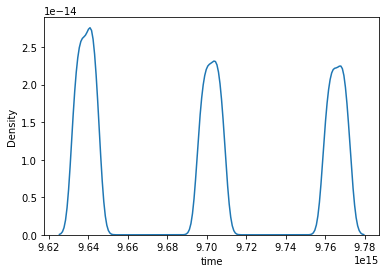

In [45]:
sns.kdeplot(data = bids, x ='time')

In [46]:
time_block = (bids['time'].max() - bids['time'].min()) / 5

In [47]:
time_start_1 = bids['time'].min()
time_end_1 = time_start_1 + time_block

In [48]:
time_start_2 = time_end_1
time_end_2 = time_start_2 + time_block

In [49]:
time_start_3 = time_end_2
time_end_3 = time_start_3 + time_block

In [50]:
time_start_4 = time_end_3
time_end_4 = time_start_4 + time_block

In [51]:
time_start_5 = time_end_4
time_end_5 =  time_start_5 + time_block

In [52]:
bids_first_block = bids[(bids['time'] >= time_start_1) & (bids['time'] < time_end_1)]
bids_second_block = bids[(bids['time'] >= time_start_2) & (bids['time'] < time_end_2)]
bids_third_block = bids[(bids['time'] >= time_start_3) & (bids['time'] < time_end_3)]
bids_fourth_block = bids[(bids['time'] >= time_start_4) & (bids['time'] < time_end_4)]
bids_fifth_block = bids[(bids['time'] >= time_start_5) & (bids['time'] < time_end_5)]

By zooming in to one of the time blocks, we also see a "wave" pattern, which indicates that there are period of time where bidding activity is high or low. From this, we assume that there would be less bidding activity during the silent hours (e.g. from midnight to dawn when humans would be asleep). This could help in identifying whether a bidder is bot or human.

<AxesSubplot:xlabel='time', ylabel='Density'>

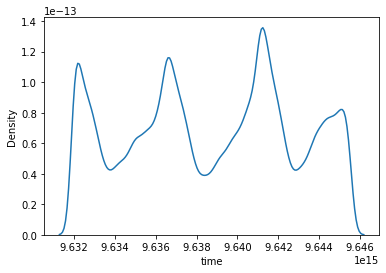

In [53]:
sns.kdeplot(data = bids_first_block, x = 'time')

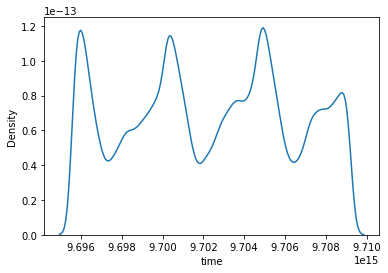

In [54]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns

ax = sns.kdeplot(data = bids_third_block, x = 'time')
x = ax.lines[0].get_xdata() # Get the x data of the distribution
y = ax.lines[0].get_ydata() # Get the y data of the distribution
xy = [[x[i], y[i]] for i in range(len(x))]

# find peak
peak_coord = [xy[i] for i in find_peaks(y)[0]]
#sorted_peak = sorted(peak_coord, key=lambda x: x[1])

# sort peak based on its `y` coord
#sorted_peak.reverse()
# second peak
#second_peak = sorted_peak[1]

In [55]:
peak_coord

[[9695991069379348.0, 1.175369960412207e-13],
 [9700339344260208.0, 1.1438110423682936e-13],
 [9703713005805704.0, 7.711486305935637e-14],
 [9704912529910768.0, 1.1898782255522677e-13],
 [9708810983252230.0, 8.1665306723761e-14]]

In [56]:
time_between_peak = peak_coord[3][0] - peak_coord[1][0]

In [57]:
sixhr_time_block = time_between_peak / 4

In [58]:
sixhr_time_block

1143296412640.0

In [59]:
evening0 = time_start_1 + sixhr_time_block
night0 = evening0 + sixhr_time_block
morning1 = night0 + sixhr_time_block
afternoon1 = morning1 + sixhr_time_block
evening1 = afternoon1 + sixhr_time_block
night1 = evening1 + sixhr_time_block
morning2 = night1 + sixhr_time_block
afternoon2 = morning2 + sixhr_time_block
evening2 = afternoon2 + sixhr_time_block
night2 = evening2 + sixhr_time_block
morning3 = night2 + sixhr_time_block
afternoon3 = morning3 + sixhr_time_block
evening3 = afternoon3 + sixhr_time_block

In [60]:
def set_hour(x):
    if (x >= 9631916842105263) and (x<= 9645558894736842):
        start_time = 9631916842105263
        evening0 = start_time + sixhr_time_block
        night0 = evening0 + sixhr_time_block
        morning1 = night0 + sixhr_time_block
        afternoon1 = morning1 + sixhr_time_block
        evening1 = afternoon1 + sixhr_time_block
        night1 = evening1 + sixhr_time_block
        morning2 = night1 + sixhr_time_block
        afternoon2 = morning2 + sixhr_time_block
        evening2 = afternoon2 + sixhr_time_block
        night2 = evening2 + sixhr_time_block
        morning3 = night2 + sixhr_time_block
        afternoon3 = morning3 + sixhr_time_block
        evening3 = afternoon3 + sixhr_time_block
        
        if (x >= start_time) and (x < evening0):
            return 3
        elif (x >= evening0) and (x < night0):
            return 4
        elif (x >= night0) and (x < morning1):
            return 1
        elif (x >= morning1) and (x < afternoon1):
            return 2
        elif (x >= afternoon1) and (x < evening1):
            return 3
        elif (x >= evening1) and (x < night1):
            return 4
        elif (x >= night1) and (x < morning2):
            return 1
        elif (x >= morning2) and (x < afternoon2):
            return 2
        elif (x >= afternoon2) and (x < evening2):
            return 3
        elif (x >= evening2) and (x < night2):
            return 4
        elif (x >= night2) and (x < morning3):
            return 1
        elif (x >= morning3) and (x < afternoon3):
            return 2
        elif (x >= afternoon3) and (x < evening3):
            return 3
        
    elif (x >= 9695580000000000) and (x<= 9709222052631578):
        start_time = 9695580000000000
        evening0 = start_time + sixhr_time_block
        night0 = evening0 + sixhr_time_block
        morning1 = night0 + sixhr_time_block
        afternoon1 = morning1 + sixhr_time_block
        evening1 = afternoon1 + sixhr_time_block
        night1 = evening1 + sixhr_time_block
        morning2 = night1 + sixhr_time_block
        afternoon2 = morning2 + sixhr_time_block
        evening2 = afternoon2 + sixhr_time_block
        night2 = evening2 + sixhr_time_block
        morning3 = night2 + sixhr_time_block
        afternoon3 = morning3 + sixhr_time_block
        evening3 = afternoon3 + sixhr_time_block
        
        if (x >= start_time) and (x < evening0):
            return 3
        elif (x >= evening0) and (x < night0):
            return 4
        elif (x >= night0) and (x < morning1):
            return 1
        elif (x >= morning1) and (x < afternoon1):
            return 2
        elif (x >= afternoon1) and (x < evening1):
            return 3
        elif (x >= evening1) and (x < night1):
            return 4
        elif (x >= night1) and (x < morning2):
            return 1
        elif (x >= morning2) and (x < afternoon2):
            return 2
        elif (x >= afternoon2) and (x < evening2):
            return 3
        elif (x >= evening2) and (x < night2):
            return 4
        elif (x >= night2) and (x < morning3):
            return 1
        elif (x >= morning3) and (x < afternoon3):
            return 2
        elif (x >= afternoon3) and (x < evening3):
            return 3
        
    elif (x >= 9759243157894736) and (x<= 9772885210526315):
        start_time = 9759243157894736
        evening0 = start_time + sixhr_time_block
        night0 = evening0 + sixhr_time_block
        morning1 = night0 + sixhr_time_block
        afternoon1 = morning1 + sixhr_time_block
        evening1 = afternoon1 + sixhr_time_block
        night1 = evening1 + sixhr_time_block
        morning2 = night1 + sixhr_time_block
        afternoon2 = morning2 + sixhr_time_block
        evening2 = afternoon2 + sixhr_time_block
        night2 = evening2 + sixhr_time_block
        morning3 = night2 + sixhr_time_block
        afternoon3 = morning3 + sixhr_time_block
        evening3 = afternoon3 + sixhr_time_block
        
        if (x >= start_time) and (x < evening0):
            return 3
        elif (x >= evening0) and (x < night0):
            return 4
        elif (x >= night0) and (x < morning1):
            return 1
        elif (x >= morning1) and (x < afternoon1):
            return 2
        elif (x >= afternoon1) and (x < evening1):
            return 3
        elif (x >= evening1) and (x < night1):
            return 4
        elif (x >= night1) and (x < morning2):
            return 1
        elif (x >= morning2) and (x < afternoon2):
            return 2
        elif (x >= afternoon2) and (x < evening2):
            return 3
        elif (x >= evening2) and (x < night2):
            return 4
        elif (x >= night2) and (x < morning3):
            return 1
        elif (x >= morning3) and (x < afternoon3):
            return 2
        elif (x >= afternoon3) and (x < evening3):
            return 3

In [61]:
bids['period'] = bids['time'].apply(set_hour)

In [62]:
bids_period = bids.groupby('bidder_id')['period'].apply(lambda x: x.value_counts().head(1)).reset_index()

In [63]:
bids_period.rename({'level_1': 'tod'}, axis=1, inplace=True)

In [64]:
bids_period_all = bids.groupby(['bidder_id','period']).size().reset_index()

In [65]:
bids_period_all = bids_period_all.rename({0: 'count_period'}, axis=1)

In [66]:
bids_period_all_unmelt = bids_period_all.pivot_table(values = 'count_period', index = 'bidder_id', columns = 'period').reset_index()

In [67]:
rename_dict = {1: 'morning', 2:'afternoon', 3:'evening', 4:'night'}
bids_period_all_unmelt = bids_period_all_unmelt.rename(rename_dict, axis=1)

In [68]:
bids_period_all_unmelt = bids_period_all_unmelt.fillna(0)

In [69]:
bids_period_count = bids_period_all_unmelt

## Bids Per Time Block

Since we have identified three time blocks where bidding took place, we tried to see if aggregate the bids placed in each time block. The hypothesis is that a bot would be more active in placing bids and hence more likely to be bidding across all three time blocks.

In [70]:
bids_block1 = bids[(bids['time'] >= 9631916842105263) & (bids['time'] <= 9645558894736842)]
bids_block1 = bids_block1.groupby('bidder_id').size().reset_index().rename({0: 'bids_block1'}, axis=1)

In [71]:
bids_block2 = bids[(bids['time'] >= 9695580000000000) & (bids['time'] <= 9709222052631578)]
bids_block2 = bids_block2.groupby('bidder_id').size().reset_index().rename({0: 'bids_block2'}, axis=1)

In [72]:
bids_block3 = bids[(bids['time'] >= 9759243157894736) & (bids['time'] <= 9772885210526315)]
bids_block3 = bids_block3.groupby('bidder_id').size().reset_index().rename({0: 'bids_block3'}, axis=1)

In [73]:
bids_blocks = pd.merge(bids_block1, bids_block2, how = 'outer')
bids_blocks = pd.merge(bids_blocks, bids_block3, how = 'outer')
bids_blocks = bids_blocks.fillna(0)

In [74]:
bids_blocks['mean_bids_blocks'] = (bids_blocks['bids_block1'] + bids_blocks['bids_block2'] + bids_blocks['bids_block3'])/3

## Grouping Country to Continent

We also tried to see if there is any pattern for country. As there are too many unique countries, we tried to aggregate them by continent and created a new categorical feature.

In [75]:
cc_dict = {'af': 'Asia', 'al': 'Europe', 'aq': 'Antarctica', 'dz': 'Africa', 'as': 'Oceania', 'ad': 'Europe', 'ao': 'Africa', 'ag': 'North America', 'az': 'Asia', 'ar': 'South America', 'au': 'Oceania', 'at': 'Europe', 'bs': 'North America', 'bh': 'Asia', 'bd': 'Asia', 'am': 'Asia', 'bb': 'North America', 'be': 'Europe', 'bm': 'North America', 'bt': 'Asia', 'bo': 'South America', 'ba': 'Europe', 'bw': 'Africa', 'bv': 'Antarctica', 'br': 'South America', 'bz': 'North America', 'io': 'Asia', 'sb': 'Oceania', 'vg': 'North America', 'bn': 'Asia', 'bg': 'Europe', 'mm': 'Asia', 'bi': 'Africa', 'by': 'Europe', 'kh': 'Asia', 'cm': 'Africa', 'ca': 'North America', 'cv': 'Africa', 'ky': 'North America', 'cf': 'Africa', 'lk': 'Asia', 'td': 'Africa', 'cl': 'South America', 'cn': 'Asia', 'tw': 'Asia', 'cx': 'Asia', 'cc': 'Asia', 'co': 'South America', 'km': 'Africa', 'yt': 'Africa', 'cg': 'Africa', 'cd': 'Africa', 'ck': 'Oceania', 'cr': 'North America', 'hr': 'Europe', 'cu': 'North America', 'cy': 'Asia', 'cz': 'Europe', 'bj': 'Africa', 'dk': 'Europe', 'dm': 'North America', 'do': 'North America', 'ec': 'South America', 'sv': 'North America', 'gq': 'Africa', 'et': 'Africa', 'er': 'Africa', 'ee': 'Europe', 'fo': 'Europe', 'fk': 'South America', 'gs': 'Antarctica', 'fj': 'Oceania', 'fi': 'Europe', 'ax': 'Europe', 'fr': 'Europe', 'gf': 'South America', 'pf': 'Oceania', 'tf': 'Antarctica', 'dj': 'Africa', 'ga': 'Africa', 'ge': 'Asia', 'gm': 'Africa', 'ps': 'Asia', 'de': 'Europe', 'gh': 'Africa', 'gi': 'Europe', 'ki': 'Oceania', 'gr': 'Europe', 'gl': 'North America', 'gd': 'North America', 'gp': 'North America', 'gu': 'Oceania', 'gt': 'North America', 'gn': 'Africa', 'gy': 'South America', 'ht': 'North America', 'hm': 'Antarctica', 'va': 'Europe', 'hn': 'North America', 'hk': 'Asia', 'hu': 'Europe', 'is': 'Europe', 'in': 'Asia', 'id': 'Asia', 'ir': 'Asia', 'iq': 'Asia', 'ie': 'Europe', 'il': 'Asia', 'it': 'Europe', 'ci': 'Africa', 'jm': 'North America', 'jp': 'Asia', 'kz': 'Asia', 'jo': 'Asia', 'ke': 'Africa', 'kp': 'Asia', 'kr': 'Asia', 'kw': 'Asia', 'kg': 'Asia', 'la': 'Asia', 'lb': 'Asia', 'ls': 'Africa', 'lv': 'Europe', 'lr': 'Africa', 'ly': 'Africa', 'li': 'Europe', 'lt': 'Europe', 'lu': 'Europe', 'mo': 'Asia', 'mg': 'Africa', 'mw': 'Africa', 'my': 'Asia', 'mv': 'Asia', 'ml': 'Africa', 'mt': 'Europe', 'mq': 'North America', 'mr': 'Africa', 'mu': 'Africa', 'mx': 'North America', 'mc': 'Europe', 'mn': 'Asia', 'md': 'Europe', 'me': 'Europe', 'ms': 'North America', 'ma': 'Africa', 'mz': 'Africa', 'om': 'Asia', 'na': 'Africa', 'nr': 'Oceania', 'np': 'Asia', 'nl': 'Europe', 'an': 'North America', 'cw': 'North America', 'aw': 'North America', 'sx': 'North America', 'bq': 'North America', 'nc': 'Oceania', 'vu': 'Oceania', 'nz': 'Oceania', 'ni': 'North America', 'ne': 'Africa', 'ng': 'Africa', 'nu': 'Oceania', 'nf': 'Oceania', 'no': 'Europe', 'mp': 'Oceania', 'um': 'North America', 'fm': 'Oceania', 'mh': 'Oceania', 'pw': 'Oceania', 'pk': 'Asia', 'pa': 'North America', 'pg': 'Oceania', 'py': 'South America', 'pe': 'South America', 'ph': 'Asia', 'pn': 'Oceania', 'pl': 'Europe', 'pt': 'Europe', 'gw': 'Africa', 'tl': 'Asia', 'pr': 'North America', 'qa': 'Asia', 're': 'Africa', 'ro': 'Europe', 'ru': 'Asia', 'rw': 'Africa', 'bl': 'North America', 'sh': 'Africa', 'kn': 'North America', 'ai': 'North America', 'lc': 'North America', 'mf': 'North America', 'pm': 'North America', 'vc': 'North America', 'sm': 'Europe', 'st': 'Africa', 'sa': 'Asia', 'sn': 'Africa', 'rs': 'Europe', 'sc': 'Africa', 'sl': 'Africa', 'sg': 'Asia', 'sk': 'Europe', 'vn': 'Asia', 'si': 'Europe', 'so': 'Africa', 'za': 'Africa', 'zw': 'Africa', 'es': 'Europe', 'ss': 'Africa', 'eh': 'Africa', 'sd': 'Africa', 'sr': 'South America', 'sj': 'Europe', 'sz': 'Africa', 'se': 'Europe', 'ch': 'Europe', 'sy': 'Asia', 'tj': 'Asia', 'th': 'Asia', 'tg': 'Africa', 'tk': 'Oceania', 'to': 'Oceania', 'tt': 'North America', 'ae': 'Asia', 'tn': 'Africa', 'tr': 'Asia', 'tm': 'Asia', 'tc': 'North America', 'tv': 'Oceania', 'ug': 'Africa', 'ua': 'Europe', 'mk': 'Europe', 'eg': 'Africa', 'gb': 'Europe', 'uk': 'Europe', 'gg': 'Europe', 'je': 'Europe', 'im': 'Europe', 'tz': 'Africa', 'us': 'North America', 'vi': 'North America', 'bf': 'Africa', 'uy': 'South America', 'uz': 'Asia', 've': 'South America', 'wf': 'Oceania', 'ws': 'Oceania', 'ye': 'Asia', 'zm': 'Africa', 'xx': 'Oceania', 'xe': 'Asia', 'xd': 'Asia', 'xs': 'Asia', 'zz': 'Unknown', 'eu': 'Europe'}

In [76]:
bids_country = pd.DataFrame(bids[['bidder_id','country', 'ip']].copy())

In [77]:
bids_country.head()

,bidder_id,country,ip
0,c6faf9e526c72bc8383f2bc4417a465d2fa27,us,69.166.231.58
1,d96e93359ed70b7b4eebac163f448afeb50dc,in,50.201.125.84
2,065bdcc596308d1fdd0014261d6e198aa138e,py,112.54.208.157
3,e97aa310037dd210f52b5b164077a926bb5de,in,18.99.175.133
4,41a7f56fcc5771d305baa6e989fb2e8cceb21,in,145.138.5.37


In [78]:
bids_country.iloc[1038739, 1] = 'th'
bids_country.iloc[2040266, 1] = 'th'

In [79]:
bids_country.iloc[5566304, 1] = 'my'
bids_country.iloc[6614612, 1] = 'my'
bids_country.iloc[6726177, 1] = 'my'
bids_country.iloc[7357215, 1] = 'my'
bids_country.iloc[7453716, 1] = 'my'

In [80]:
bids_country = bids_country.fillna('missing')

In [81]:
def country_to_continent(x):
    if x == 'missing':
        return 'Unknown'
    else:
        return cc_dict[x]

In [82]:
bids_country['continent'] = bids_country['country'].apply(country_to_continent)

In [83]:
bids_country['continent'].unique()

array(['North America', 'Asia', 'South America', 'Africa', 'Oceania',
       'Europe', 'Unknown'], dtype=object)

In [84]:
bids_country_all = bids_country.groupby(['bidder_id','continent']).size().reset_index()

In [85]:
bids_country_all = bids_country_all.rename({0: 'count_continent'}, axis=1)

In [86]:
bids_country_all_unmelt = bids_country_all.pivot_table(values = 'count_continent', index = 'bidder_id', columns = 'continent').reset_index()

In [87]:
bids_country_all_unmelt = bids_country_all_unmelt.fillna(0)

In [88]:
bids_country_count = bids_country_all_unmelt

## Creating Type of Payment Account

We notice that for the payment account, the unique values are the last 5 characters. For the first 32 characters, there are some sort of pattern and they may be representative of the type of acocunt (for example like credit card, Visa cards begin with 4 and have 13/16 digits, while Mastercards begin with 5 and have 16 digits). The hypothesis is that bots may be more inclined to use certain payment account that is more obscured.

In [89]:
combine_pay = pd.concat([train, test], axis = 0)

In [90]:
def extract_32(x):
    return x[:32]

In [91]:
combine_pay['first32'] = combine_pay['payment_account'].apply(extract_32)

In [92]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
combine_pay['first32_encode'] = le.fit_transform(combine_pay['first32'])

In [93]:
combine_pay = combine_pay.drop(['payment_account', 'address', 'outcome', 'first32'], axis=1)

In [94]:
combine_pay.head()

,bidder_id,first32_encode
0,4a791121f1d9c9c192d13051301984388c491,1631
1,6feeeab451fcc546e1c43867e04bd5d2294fc,1631
2,0bdfae6168380fa2e00853fd3d6199ba8ed7d,1631
3,3b4586382b3ff164e8bad37b15a268a540996,801
4,10c7f4bdc67a50bab856b9ca76a83ce980f96,1631


## Combine all datasets

In [95]:
#bids_period = pd.read_csv('bids_period.csv')

In [96]:
#bids_period_count = pd.read_csv('bids_period_count.csv')

In [97]:
#bids_country_count = pd.read_csv('bids_country_count.csv')

In [98]:
first = pd.merge(combine, bidder, how = 'left', on = 'bidder_id')
second = pd.merge(first, time_final, how = 'left', on = 'bidder_id')
final = pd.merge(second, full_bids, how = 'left', on = 'bidder_id')
final = pd.merge(final, bids_period, how = 'left', on = 'bidder_id')
final = pd.merge(final, top_elements, how = 'left', on = 'bidder_id')
final = pd.merge(final, bids_period_count, how = 'left', on = 'bidder_id')
final = pd.merge(final, bids_country_count, how = 'left', on = 'bidder_id')
final = pd.merge(final, combine_pay, how = 'left', on = 'bidder_id')
final = pd.merge(final, bids_blocks, how = 'left', on = 'bidder_id')

In [99]:
final.drop(columns = ['payment_account', 'address'], inplace = True)

In [100]:
final.shape

(6713, 75)

In [101]:
final['merauction'] = final['merchandise'] / final['auction']
final['ipauction'] = final['ip'] / final['auction']
final['devauction'] = final['device'] / final['auction']
final['urlauction'] = final['url'] / final['auction']

In [102]:
train_final = final[:2013]
test_final = final[2013:]

In [103]:
train_final.head(10)

,bidder_id,outcome,bid_id,auction,merchandise,device,country,ip,url,adevice,aauction,aurl,aip,amerchandise,acountry,win,mean_time,mean_time_scaled,med_time,med_time_scaled,multi_bids,num_multi_bids,med_raw_time,mean_raw_time,first,switchip,switchurl,switchdevice,avg_ip,avg_device,avg_url,avg_bid,tod,period,auction_1st,auction_2nd,auction_3rd,auction_4th,auction_5th,device_1st,device_2nd,device_3rd,device_4th,device_5th,country_1st,country_2nd,country_3rd,country_4th,country_5th,ip_1st,ip_2nd,ip_3rd,ip_4th,ip_5th,url_1st,url_2nd,url_3rd,url_4th,url_5th,morning,afternoon,evening,night,Africa,Asia,Europe,North America,Oceania,South America,Unknown,first32_encode,bids_block1,bids_block2,bids_block3,mean_bids_blocks,merauction,ipauction,devauction,urlauction
0,4a791121f1d9c9c192d13051301984388c491,0.0,24.0,18.0,1.0,14.0,6.0,20.0,1.0,0.583333,0.750000,0.041667,0.833333,0.041667,0.250000,0.0,5.711121e+11,0.007504,3.458421e+11,0.004544,1.0,0.0,9.764806e+15,9.766127e+15,0.0,6.913463e+11,0.000000e+00,1.010429e+12,1.0,1.0,1.0,1.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,5.0,11.0,8.0,0.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,1631,0.0,0.0,24.0,8.000000,0.055556,1.111111,0.777778,0.055556
1,6feeeab451fcc546e1c43867e04bd5d2294fc,0.0,3.0,1.0,1.0,2.0,1.0,3.0,2.0,0.666667,0.333333,0.666667,1.000000,0.333333,0.333333,0.0,3.233579e+12,0.042490,3.233579e+12,0.042490,1.0,0.0,9.766036e+15,9.766866e+15,0.0,3.233579e+12,6.467158e+12,6.467158e+12,3.0,2.0,2.0,3.0,4.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1631,0.0,0.0,3.0,1.000000,1.000000,3.000000,2.000000,2.000000
2,0bdfae6168380fa2e00853fd3d6199ba8ed7d,0.0,4.0,4.0,1.0,2.0,1.0,4.0,2.0,0.500000,1.000000,0.500000,1.000000,0.250000,0.250000,0.0,2.379000e+12,0.031260,2.532053e+12,0.033271,1.0,0.0,9.769820e+15,9.769395e+15,0.0,2.379000e+12,3.154105e+12,3.154105e+12,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1631,0.0,0.0,4.0,1.333333,0.250000,1.000000,0.500000,0.500000
3,3b4586382b3ff164e8bad37b15a268a540996,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,NaN,1.0,0.0,9.706442e+15,9.706442e+15,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,801,0.0,1.0,0.0,0.333333,1.000000,1.000000,1.000000,1.000000
4,10c7f4bdc67a50bab856b9ca76a83ce980f96,0.0,155.0,23.0,1.0,53.0,2.0,123.0,91.0,0.341935,0.148387,0.587097,0.793548,0.006452,0.012903,0.0,7.777888e+10,0.001022,1.368421e+10,0.000180,1.0,0.0,9.761839e+15,9.762118e+15,0.0,9.817990e+10,1.330883e+11,1.820516e+11,2.0,2.0,2.0,2.0,3.0,76.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,1.0,0.0,11.0,154.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,53.0,6.0,76.0,20.0,0.0,154.0,0.0,1.0,0.0,0.0,0.0,1631,0.0,0.0,155.0,51.666667,0.043478,5.347826,2.304348,3.956522
5,c3904e52ba5c4ce978a9f451a1665c8bd51d4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,NaN,1.0,0.0,9.761130e+15,9.761130e+15,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1631,0.0,0.0,1.0,0.333333,1.000000,1.000000,1.000000,1.000000
6,2e421b3e55923090bc2809d35c6046beb356d,0.0,8.0,8.0,1.0,2.0,1.0,3.0,8.0,0.250000,1.000000,1.000000,0.375000,0.125000,0.125000,0.0,1.598902e+12,0.021010,5.842105e+10,0.000768,1.0,0.0,9.761140e+15,9.763141e+15,0.0,2.131289e+12,1.598902e+12,4.262579e+12,1.0,1.0,1.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [104]:
b = train_final[train_final['outcome'] == 1]
h = train_final[train_final['outcome'] == 0]

<AxesSubplot:xlabel='mean_bids_blocks', ylabel='Density'>

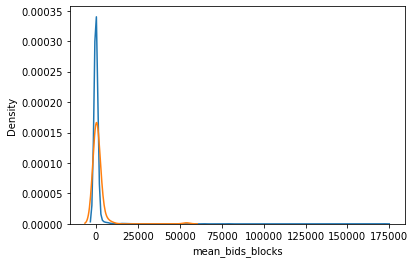

In [105]:
sns.kdeplot(data = h, x = 'mean_bids_blocks') #blue
sns.kdeplot(data = b, x = 'mean_bids_blocks') #orange

In [106]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2013 entries, 0 to 2012
Data columns (total 79 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bidder_id         2013 non-null   object 
 1   outcome           2013 non-null   float64
 2   bid_id            1984 non-null   float64
 3   auction           1984 non-null   float64
 4   merchandise       1984 non-null   float64
 5   device            1984 non-null   float64
 6   country           1984 non-null   float64
 7   ip                1984 non-null   float64
 8   url               1984 non-null   float64
 9   adevice           1984 non-null   float64
 10  aauction          1984 non-null   float64
 11  aurl              1984 non-null   float64
 12  aip               1984 non-null   float64
 13  amerchandise      1984 non-null   float64
 14  acountry          1984 non-null   float64
 15  win               1984 non-null   float64
 16  mean_time         1682 non-null   float64


In [107]:
test_final = test_final.drop(columns = ['outcome'])

In [108]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4700 entries, 2013 to 6712
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bidder_id         4700 non-null   object 
 1   bid_id            4630 non-null   float64
 2   auction           4630 non-null   float64
 3   merchandise       4630 non-null   float64
 4   device            4630 non-null   float64
 5   country           4630 non-null   float64
 6   ip                4630 non-null   float64
 7   url               4630 non-null   float64
 8   adevice           4630 non-null   float64
 9   aauction          4630 non-null   float64
 10  aurl              4630 non-null   float64
 11  aip               4630 non-null   float64
 12  amerchandise      4630 non-null   float64
 13  acountry          4630 non-null   float64
 14  win               4630 non-null   float64
 15  mean_time         3875 non-null   float64
 16  mean_time_scaled  3875 non-null   float

In [109]:
train_final = train_final.fillna(0)
#train_final.dropna(inplace=True)

In [110]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2013 entries, 0 to 2012
Data columns (total 79 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bidder_id         2013 non-null   object 
 1   outcome           2013 non-null   float64
 2   bid_id            2013 non-null   float64
 3   auction           2013 non-null   float64
 4   merchandise       2013 non-null   float64
 5   device            2013 non-null   float64
 6   country           2013 non-null   float64
 7   ip                2013 non-null   float64
 8   url               2013 non-null   float64
 9   adevice           2013 non-null   float64
 10  aauction          2013 non-null   float64
 11  aurl              2013 non-null   float64
 12  aip               2013 non-null   float64
 13  amerchandise      2013 non-null   float64
 14  acountry          2013 non-null   float64
 15  win               2013 non-null   float64
 16  mean_time         2013 non-null   float64


In [111]:
test_final = test_final.fillna(0)
#test_final.dropna(inplace=True)

In [112]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4700 entries, 2013 to 6712
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bidder_id         4700 non-null   object 
 1   bid_id            4700 non-null   float64
 2   auction           4700 non-null   float64
 3   merchandise       4700 non-null   float64
 4   device            4700 non-null   float64
 5   country           4700 non-null   float64
 6   ip                4700 non-null   float64
 7   url               4700 non-null   float64
 8   adevice           4700 non-null   float64
 9   aauction          4700 non-null   float64
 10  aurl              4700 non-null   float64
 11  aip               4700 non-null   float64
 12  amerchandise      4700 non-null   float64
 13  acountry          4700 non-null   float64
 14  win               4700 non-null   float64
 15  mean_time         4700 non-null   float64
 16  mean_time_scaled  4700 non-null   float

## Building Models

In [113]:
final.head(1)

,bidder_id,outcome,bid_id,auction,merchandise,device,country,ip,url,adevice,aauction,aurl,aip,amerchandise,acountry,win,mean_time,mean_time_scaled,med_time,med_time_scaled,multi_bids,num_multi_bids,med_raw_time,mean_raw_time,first,switchip,switchurl,switchdevice,avg_ip,avg_device,avg_url,avg_bid,tod,period,auction_1st,auction_2nd,auction_3rd,auction_4th,auction_5th,device_1st,device_2nd,device_3rd,device_4th,device_5th,country_1st,country_2nd,country_3rd,country_4th,country_5th,ip_1st,ip_2nd,ip_3rd,ip_4th,ip_5th,url_1st,url_2nd,url_3rd,url_4th,url_5th,morning,afternoon,evening,night,Africa,Asia,Europe,North America,Oceania,South America,Unknown,first32_encode,bids_block1,bids_block2,bids_block3,mean_bids_blocks,merauction,ipauction,devauction,urlauction
0,4a791121f1d9c9c192d13051301984388c491,0.0,24.0,18.0,1.0,14.0,6.0,20.0,1.0,0.583333,0.75,0.041667,0.833333,0.041667,0.25,0.0,5.711121e+11,0.007504,3.458421e+11,0.004544,1.0,0.0,9.764806e+15,9.766127e+15,0.0,6.913463e+11,0.0,1.010429e+12,1.0,1.0,1.0,1.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,5.0,11.0,8.0,0.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,1631,0.0,0.0,24.0,8.0,0.055556,1.111111,0.777778,0.055556


In [114]:
corr = final.corr()
#corr

In [115]:
train_final.columns

Index(['bidder_id', 'outcome', 'bid_id', 'auction', 'merchandise', 'device',
       'country', 'ip', 'url', 'adevice', 'aauction', 'aurl', 'aip',
       'amerchandise', 'acountry', 'win', 'mean_time', 'mean_time_scaled',
       'med_time', 'med_time_scaled', 'multi_bids', 'num_multi_bids',
       'med_raw_time', 'mean_raw_time', 'first', 'switchip', 'switchurl',
       'switchdevice', 'avg_ip', 'avg_device', 'avg_url', 'avg_bid', 'tod',
       'period', 'auction_1st', 'auction_2nd', 'auction_3rd', 'auction_4th',
       'auction_5th', 'device_1st', 'device_2nd', 'device_3rd', 'device_4th',
       'device_5th', 'country_1st', 'country_2nd', 'country_3rd',
       'country_4th', 'country_5th', 'ip_1st', 'ip_2nd', 'ip_3rd', 'ip_4th',
       'ip_5th', 'url_1st', 'url_2nd', 'url_3rd', 'url_4th', 'url_5th',
       'morning', 'afternoon', 'evening', 'night', 'Africa', 'Asia', 'Europe',
       'North America', 'Oceania', 'South America', 'Unknown',
       'first32_encode', 'bids_block1', 'bids_b

In [128]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score

# trying cost sensitive learning
from sklearn.utils import class_weight


features = ['bid_id', 'auction', 'merchandise', 'device', 'country', 
            'ip', 'url', 'adevice', 'aauction', 'aurl', 
            'aip','amerchandise', 'acountry', 'win', 'mean_time', 
            'mean_time_scaled','med_time', 'med_time_scaled', 'multi_bids', 'num_multi_bids',
            'med_raw_time', 'mean_raw_time', 'first', 'avg_ip', 'avg_device',
            'avg_url', 'avg_bid', 'tod', 'period', 'auction_1st', 
            'auction_2nd','auction_3rd', 'device_1st', 'device_2nd', 'device_3rd', 
            'country_1st','country_2nd', 'country_3rd', 'ip_1st', 'ip_2nd', 
            'ip_3rd', 'url_1st','url_2nd', 'url_3rd', 'auction_4th', 
            'auction_5th', 'device_4th', 'device_5th', 'country_4th', 'country_5th',
            'ip_4th', 'ip_5th', 'url_4th', 'url_5th', 'morning', 
            'afternoon', 'evening', 'night','Africa', 'Asia', 
            'Europe', 'North America', 'Oceania', 'South America','Unknown', 
            'first32_encode','merauction', 'ipauction', 'devauction', 'urlauction'] #70f

X = train_final[features]
y = train_final['outcome']

#kf = KFold(n_splits = 10, shuffle =True, random_state = 5)

# use stratified kfold
kf = StratifiedKFold(n_splits = 9, shuffle =True, random_state = 5)

k_fold_auc = []
k_fold_auc_proba = []
k_fold_auc_train = []
k_fold_mc = []
k_fold_acc = []
k_fold_err = []
k_fold_rec = []
k_fold_spec = []
k_fold_pre = []
k_fold_f1 = []
k_fold_f1_weight = []
k_fold_aps = []
k_fold_cks = []


from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler


for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 

    CV_rf = RandomForestClassifier(n_estimators = 100, max_depth = 20, min_samples_split = 3, min_samples_leaf = 1, 
                                   random_state = 5)

        
    CV_rf.fit(X_train, y_train)
    
    rf_pred = CV_rf.predict(X_train)
    auc = roc_auc_score(y_train, rf_pred)
    k_fold_auc_train.append(auc)
    
    rf_pred = CV_rf.predict(X_test)
    auc = roc_auc_score(y_test, rf_pred)
    k_fold_auc.append(auc)
    
    rf_pred = CV_rf.predict(X_test)
    mc = matthews_corrcoef(y_test, rf_pred)
    k_fold_mc.append(mc)
    
    rf_pred = CV_rf.predict(X_test)
    aps = average_precision_score(y_test, rf_pred)
    k_fold_aps.append(aps)
    
    rf_pred = CV_rf.predict(X_test)
    cks = cohen_kappa_score(y_test, rf_pred)
    k_fold_cks.append(cks)
    
    rf_pred = CV_rf.predict(X_test)
    rf_pred_proba = CV_rf.predict_proba(X_test)
    auc = roc_auc_score(y_test, rf_pred_proba[:,1])
    k_fold_auc_proba.append(auc)
    
    cm = confusion_matrix(y_test, rf_pred)
    TN, FP, FN, TP = cm.ravel()
    k_fold_acc.append(((TN+TP) / (TN+FP+FN+TP)))
    k_fold_err.append((FN+FP) / (TN+FP+FN+TP))
    k_fold_rec.append((FN+FP) / (TN+FP+FN+TP))
    k_fold_spec.append(TN / (TN+FP))
    k_fold_pre.append(TP / (TP+FP))
    k_fold_f1_weight.append(f1_score(y_test, rf_pred,average='weighted'))
    k_fold_f1.append(f1_score(y_test, rf_pred))
    

mean_auc_proba = np.mean(k_fold_auc_proba)
mean_auc = np.mean(k_fold_auc)
mean_auc_train = np.mean(k_fold_auc_train)
mean_mc = np.mean(k_fold_mc)
mean_aps = np.mean(k_fold_aps)
mean_cks = np.mean(k_fold_cks)
print(mean_auc_train)
print(mean_auc_proba)
print(mean_auc)
print(mean_mc)
print(mean_aps)
print(mean_cks)

print('Accuracy: {0:}'.format(np.mean(k_fold_acc)))
print('Error: {0:}'.format(np.mean(k_fold_err)))
print('Recall: {0:}'.format(np.mean(k_fold_rec)))
print('Specificity: {0:}'.format(np.mean(k_fold_spec)))
print('Precision: {0:}'.format(np.mean(k_fold_pre)))

print('\nF1: {0:}'.format(np.mean(k_fold_f1)))
print('\nF1 weighted: {0:}'.format(np.mean(k_fold_f1_weight)))

0.9842132505175982
0.9155094829506866
0.6340100670090041
0.4359256117109846
0.2660794991699327
0.37967551868401545
Accuracy: 0.9582799487508008
Error: 0.041720051249199225
Recall: 0.041720051249199225
Specificity: 0.9952928612907352
Precision: 0.7579365079365079

F1: 0.39582684925822176

F1 weighted: 0.9485379101646365


In [129]:
k_fold_auc

[0.6747759282970551,
 0.5885616730687154,
 0.5809748427672956,
 0.6666666666666666,
 0.7083333333333334,
 0.5345911949685533,
 0.5885506003430532,
 0.6818181818181819,
 0.6818181818181819]

In [130]:
np.std(k_fold_auc)

0.05739962765806246

In [131]:
CV_rf.feature_importances_

array([2.74649368e-02, 1.46404374e-02, 6.86297629e-04, 1.47008407e-02,
       8.47513273e-03, 1.42253783e-02, 1.71789226e-02, 2.63893040e-02,
       4.21468720e-02, 2.75195187e-02, 1.95868754e-02, 1.89992993e-02,
       2.87183171e-02, 9.63339559e-03, 1.73177763e-02, 2.10162938e-02,
       2.11235881e-02, 2.52709899e-02, 1.93616595e-02, 1.63601333e-02,
       3.22721075e-02, 3.12522932e-02, 8.01909484e-03, 4.53204202e-03,
       2.41443014e-03, 3.93431624e-03, 1.67262612e-02, 1.03958705e-02,
       4.12689213e-02, 5.65802131e-03, 5.33937438e-03, 2.87899231e-03,
       2.19614268e-02, 1.59286672e-02, 2.12550000e-02, 7.48057713e-03,
       9.53282071e-03, 1.18160005e-02, 2.60033609e-03, 2.76179466e-03,
       2.66883491e-03, 2.21816748e-02, 0.00000000e+00, 0.00000000e+00,
       4.30444559e-03, 1.43846110e-03, 1.25546083e-02, 1.33631070e-02,
       4.58577606e-03, 1.18003539e-02, 1.67823205e-03, 2.15613081e-03,
       0.00000000e+00, 8.71183458e-05, 1.80524805e-02, 2.68030805e-02,
      

In [132]:
fi = CV_rf.feature_importances_

<AxesSubplot:>

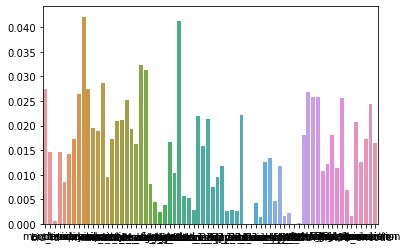

In [133]:
sns.barplot(x = features, y = fi)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
rf = RandomForestClassifier(random_state = 5)

X = train_final[features]
y = train_final['outcome']

#Creating a dictionary grid for grid search
param_grid = {'n_estimators': [150, 200, 250],
              'max_depth': [10, 20, 30],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= rf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(n_splits = 9, shuffle =True, random_state = 5), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X, y)
                          
gridsearch.best_params_

In [134]:
rf1 = RandomForestClassifier(n_estimators = 100, max_depth = 20, min_samples_split = 3, min_samples_leaf = 1, 
                               random_state = 5)
rf2 = RandomForestClassifier(n_estimators = 100, max_depth = 20, min_samples_split = 3, min_samples_leaf = 1, 
                               random_state = 10)
rf3 = RandomForestClassifier(n_estimators = 100, max_depth = 20, min_samples_split = 3, min_samples_leaf = 1, 
                               random_state = 23)
rf4 = RandomForestClassifier(n_estimators = 100, max_depth = 20, min_samples_split = 3, min_samples_leaf = 1, 
                               random_state = 47)
rf5 = RandomForestClassifier(n_estimators = 100, max_depth = 20, min_samples_split = 3, min_samples_leaf = 1, 
                               random_state = 102)

X = train_final[features]
y = train_final['outcome']

rf1.fit(X, y)
rf2.fit(X, y)
rf3.fit(X, y)
rf4.fit(X, y)
rf5.fit(X, y)

RandomForestClassifier(max_depth=20, min_samples_split=3, random_state=102)

In [135]:
y_pred1 = rf1.predict_proba(test_final[features])
y_pred2 = rf2.predict_proba(test_final[features])
y_pred3 = rf3.predict_proba(test_final[features])
y_pred4 = rf4.predict_proba(test_final[features])
y_pred5 = rf5.predict_proba(test_final[features])

In [136]:
y_pred_final = np.mean([y_pred1[:,1], y_pred2[:,1], y_pred3[:,1], y_pred4[:,1], y_pred5[:,1]], axis = 0)

In [137]:
submission = pd.DataFrame({"Id": test_final["bidder_id"], "Predicted": y_pred_final})
submission.to_csv('final_submission2.csv', index=False)